In [6]:
import pandas as pd  # requires: pip install pandas
import torch
from chronos import ChronosPipeline
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from time import perf_counter

# Read the data
df = pd.read_csv('jakobshavn.csv', na_values=[-1])

# Ensure df['Date'] is in datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Number of time series to forecast
n_timeseries = 12  # You can set this to the number of columns you want to forecast

# Select the first n_timeseries columns for forecasting
columns_to_forecast = df.columns[1:n_timeseries+1]  # +1 to skip the 'Date' column

# Initialize the pipeline
pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-small",
    device_map="cpu",  # use "cpu" for CPU inference and "mps" for Apple Silicon
    torch_dtype=torch.bfloat16,
)


# Calculate the split index for training
alpha = 0.05 
split_index = int(len(df) * (1 - alpha))

# Split the data into training and evaluation sets for all selected columns
train_data = df[columns_to_forecast].iloc[:split_index]
eval_data = df[columns_to_forecast].iloc[split_index:]

# Convert the training data to a higher-dimensional tensor
train_tensor = torch.tensor(train_data.values, dtype=torch.float32).T

# Initialize a list to store the MAE for each alpha
mae_list = []
t_list = []

t0 = perf_counter()
# Iterate over values of alpha from 0.01 to 0.1 with a step of 0.01
for n_samples in tqdm(np.arange(20, 100, 5)):

    # Perform the forecasting using the training data
    forecast = pipeline.predict(
        context=train_tensor,
        prediction_length=len(eval_data),  # Predict the same length as the evaluation set
        num_samples=n_samples,
    )

    # Calculate the Mean Absolute Error (MAE) for each time series
    mae = np.abs(forecast.mean(axis=1).T - eval_data.values).mean(axis=1).mean()

    # Append the MAE for the current alpha to the list
    mae_list.append(mae)
    t_list.append(perf_counter()-t0)

100%|██████████| 16/16 [03:05<00:00, 11.61s/it]


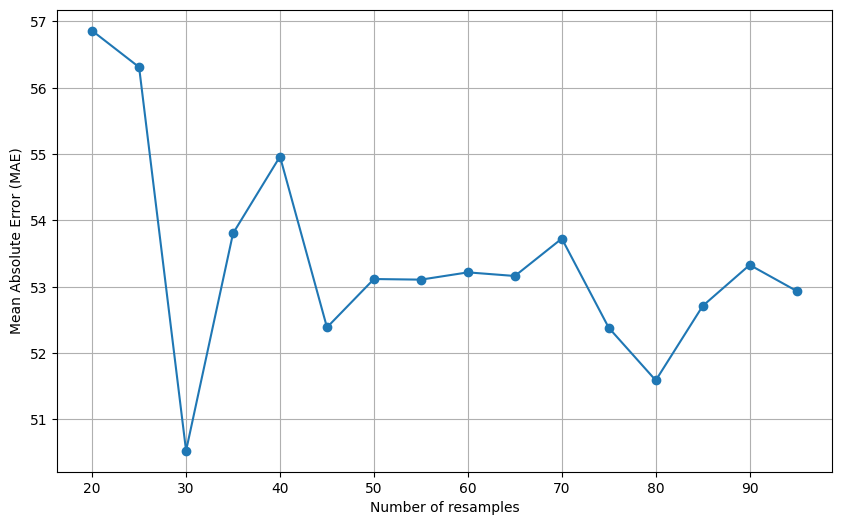

In [7]:
# Plot the MAE as a function of alpha
plt.figure(figsize=(10, 6))
plt.plot(np.arange(20, 100, 5), mae_list, marker='o')
plt.xlabel('Number of resamples')
plt.ylabel('Mean Absolute Error (MAE)')
plt.grid(True)
plt.show()